# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 11: Clouds and Climate

## Contents

1. [Clear-sky vs. all-sky radiation](#section1)
2. [Cloud Radiative Effect (CRE)](#section2)
3. [Optical properties of individual clouds depend on the Cloud Liquid Water Path](#section3)
4. [Modeling the dependence of CRE on cloud height](#section4)
5. [Cloud Feedback](#section5)

The big questions:

- Do clouds warm or cool the current climate?
- How will cloud changes affect future global warming?
    - additional warming? (positive feedback)
    - less warming? (negative feedback)

____________
<a id='section1'></a>

## 1. Clear-sky vs. all-sky radiation
____________

The horizontal extent of individual clouds is much smaller than a single grid cell of a typical GCM. Thus the top-of-atmosphere fluxes (ASR, OLR) really represent **averages** of fluxes through clear sky and fluxes through cloudy sky.

Just about every GCM computes two different types of radiative fluxes:

- All-sky flux, including the effects of clouds
- Clear-sky flux, the radiation that would occur **if no clouds were present**

The clear-sky fluxes are computed by calling the radiation code a second time but temporarily zeroing out all the clouds!

Let's start by looking at these diagnostics in the CESM model output.

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab.radiation import RRTMG
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log, exp

In [16]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset(datapath+'som_1850_f19/som_1850_f19.cam.h0.clim.nc'+endstr, decode_times=False)

Recall that in CESM terminology, the top-of-atmosphere fluxes are

- `FLNT`: "flux longwave net top", i.e. the OLR
- `FSNT`: "flux shortwave net top", i.e. the ASR

The **clear-sky** versions of these fluxes just append the letter `C` to the end of the variable name.

In [60]:
flux_names = ['FLNT', 'FLNTC', 'FSNT', 'FSNTC']
for name in flux_names:
    print(name, ': ', atm_control[name].long_name)

FLNT :  Net longwave flux at top of model
FLNTC :  Clearsky net longwave flux at top of model
FSNT :  Net solar flux at top of model
FSNTC :  Clearsky net solar flux at top of model


Let's plot the annual mean all-sky and clear-sky fluxes.

While we're at it, we'll look at an example of using the `cartopy` package in conjuction with `xarray` to do map projections of the gridded data!

/Users/br546577/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


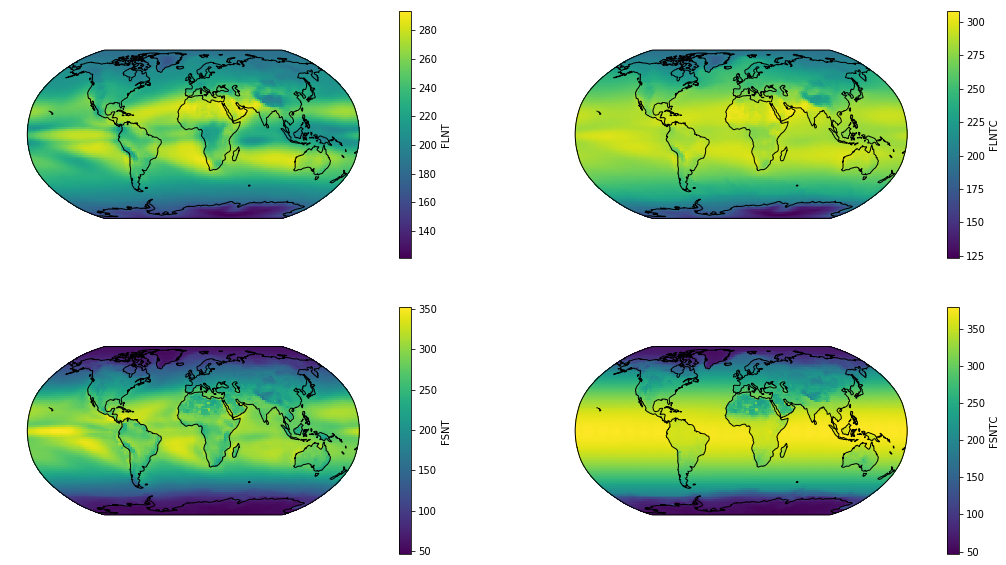

In [59]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(18,10))  # make a figure of a certain size
for n, name in enumerate(flux_names):
    # Add a subplot axis with a specific map projection 
    ax = fig.add_subplot(2,2,n+1, projection=ccrs.Robinson()) 
    # Take the annual mean of the data
    field = atm_control[name].mean(dim='time')
    #  Use the xarray .plot() method, passing it information about the desired projection
    field.plot(transform=ccrs.PlateCarree(),  # the data's projection (lat-lon)
               ax=ax)  # the axis we plot onto with the correct map projection
    ax.coastlines();  # draw coastlines!

Discuss and try make some sense of what you see here.

____________
<a id='section2'></a>

## 2. Cloud Radiative Effect (CRE)
____________

Let's denote the **net incoming radiation at TOA** as $F$:

$$  F = \text{ASR} - \text{OLR} $$ 

And denote as $F_{clear}$ the clear-sky flux (i.e. the flux in the portion of the sky **without clouds**, or equivalently, the total flux we would have with the current temperatures etc. but no clouds):

$$  F_{clear} = \text{ASR}_{clear} - \text{OLR}_{clear} $$ 


A straighforward way to quantity the warming or cooling effect of clouds is the so-called **Cloud Radiative Effect** (CRE):

$$ \text{CRE} = F - F_{clear} $$

This simple difference is **positive** if the clouds are currently providing a **warming** effect. In this case, if we instantaneously removed all the clouds, the climate would cool down.

We can of course break this up into long- and shortwave components. 

The SW contribution to the Cloud Radiative Effect is just

$$ \text{CRE}_{SW} = \text{ASR} - \text{ASR}_{clear} $$

and the LW contribution is

$$ \text{CRE}_{LW} = - \left( \text{OLR} - \text{OLR}_{clear} \right) $$

(why the minus sign in the expression for $\text{CRE}_{LW}$?)

### Python exercise

Do clouds exert a net warming or cooling effect in the CESM simulation?

To answer this, compute **global, annual mean values** for these three quantities:

- shortwave CRE
- longwave CRE
- net CRE


In [70]:
# To get started... here is an example of defining a net DataArray
# containing the SW cloud radiative effect (all sky minus clear sky)
CRE_SW_control = atm_control.FSNT - atm_control.FSNTC
print(CRE_SW_control)
#  You might want to refer back to earlier notes 
#  about taking meaningful area-weighted global averages

<xarray.DataArray (time: 12, lat: 96, lon: 144)>
array([[[-1.905991, -1.423447, ..., -1.381088, -1.45311 ],
        [-2.390656, -2.260483, ..., -2.863663, -2.653671],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[-1.950935, -1.576614, ..., -1.560394, -1.606544],
        [-2.093697, -2.039558, ..., -2.383125, -2.249657],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       ..., 
       [[-1.802032, -1.744102, ..., -1.885788, -1.763321],
        [-1.835564, -1.805183, ..., -1.897858, -1.854782],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[-1.551788, -1.368225, ..., -1.346115, -1.392593],
        [-1.542358, -1.518967, ..., -1.730865, -1.594864],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.

____________
<a id='section3'></a>

## 3. Optical properties of individual clouds depend on the Cloud Liquid Water Path
____________

Let's think about the optical properties of different cloud types to get some feeling for what might determine the CRE.

Let $w$ represent the liquid water content of a unit volume of cloudy air, in units of g m$^{-3}$.

Then the Liquid Water Path of the cloud is

$$LWP = w ~ \Delta z$$

where $\Delta z$ is the depth of the cloudy layer in meters.  $LWP$ has units of g m$^{-2}$.

$LWP$ determines the key optical properties of the cloud, both in the longwave and shortwave:

![Cloud properties](http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/CloudOpticalProperties_Webster1994.png)

Reproduced from [Webster (1994), Rev. Geophys.](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94RG01873) based on results from [Stephens (1978), J. Atmos. Sci.](https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281978%29035%3C2123%3ARPIEWC%3E2.0.CO%3B2)

A key point about the optical properties of water clouds:

- longwave emissivity / absorptivity increases rapidly with $LWP$
- cloud albedo increases slowly with $LWP$

### Longwave effects of clouds

Because the emissivity saturates for moderately thin clouds, thick clouds behave very much like blackbody absorbers at every level. Emissions from below and within the cloud will be absorbed by the upper part of the cloud.

Emissions to space are therefore **governed by the top of the cloud**.

The longwave effects of a thick cloud thus depend strongly on the **temperature at the top of the cloud**. This temperature is determined primarily by the **height of the cloud top**.

A high-top cloud will exert a strong greenhouse effect because it absorbs upwelling longwave radiation and re-emits radiation at its cold temperature.

The longwave effects of clouds tend to warm the surface.

In other words $\text{CRE}_{LW} > 0$

### Shortwave effects of clouds

Because clouds increase the planetary albedo, the shortwave effects of clouds tend to cool the surface. $\text{CRE}_{SW} < 0 $

The same cloud therefore pushes the planetary energy budget in two directions simultaneously. Which effect dominates depends on

- the temperature at the cloud top relative to the surface temperature
- the cloud liquid water path (cloud depth)

#### High thin cirrus

- Negligible albedo, $\text{CRE}_{SW} \approx 0$
- Substantial greenhouse effect because it is near the cold tropopause, $\text{CRE}_{LW} > 0$
- We conclude that these clouds must exert a **net warming effect**, $\text{CRE} > 0$

#### Low thick stratus

- Reflects significant incoming solar radiation, $\text{CRE}_{SW} < 0$
- Temperature at cloud top is **not much different from the surface temperature**, so the greenhouse effect is negligible (even though the cloud is a very strong longwave absorber!). $\text{CRE}_{LW} \approx 0$
- We conclude that these clouds must exert a **net cooling effect**, $\text{CRE} < 0$

Many other cloud types are ambiguous. For example: 

#### Deep convective cumulonimbus

- Significant reflection: $\text{CRE}_{SW} < 0$
- Strong greenhouse effect (cold cloud top): $\text{CRE}_{LW} > 0$
- Cloud could be either warming or cooling

We need a model to work out the details!

____________
<a id='section4'></a>

## 4. Modeling the dependence of CRE on cloud height
____________

We are now going to use the `RRTMG` radiation model to compute the cloud radiative effect in a single column, and look at how the CRE depends on cloud properties and the height of the cloud layer.

### Global average observed temperature and specific humidity

In [2]:
#  Get temperature and humidity data from NCEP Reanalysis
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
ncep_air = xr.open_dataset(path + 'air.mon.1981-2010.ltm.nc', decode_times=False)
ncep_shum = xr.open_dataset(path + 'shum.mon.1981-2010.ltm.nc', decode_times=False)

In [3]:
#  Take global, annual average and convert to correct units (Kelvin and kg/kg)
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time')) + climlab.constants.tempCtoK
SHglobal = (ncep_shum.shum * weight).mean(dim=('lat','lon','time')) * 1E-3  # kg/kg

Since we will be creating a radiative model with a different set of pressure levels than the data, we will need to do some interpolating.

In [4]:
#  Create a state dictionary with 50 levels
state = climlab.column_state(num_lev=50)
lev = state.Tatm.domain.axes['lev'].points

In [5]:
# interpolate to model pressure levels
Tinterp = np.interp(lev, np.flipud(Tglobal.level), np.flipud(Tglobal))
SHinterp = np.interp(lev, np.flipud(SHglobal.level), np.flipud(SHglobal))
#  Need to 'flipud' because the interpolation routine 
#  needs the pressure data to be in increasing order

Text(0.5,1.03,'Global mean air temperature and specific humidity')

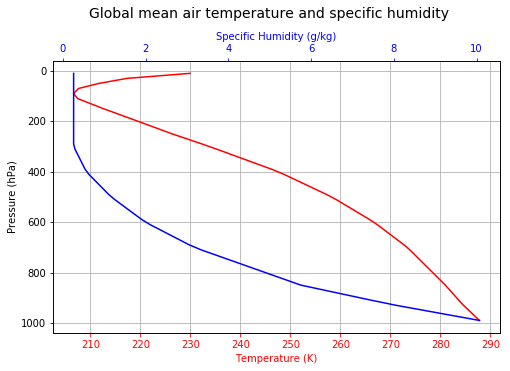

In [6]:
#  Plot the temperature and humidity profiles
fig, ax1 = plt.subplots(figsize=(8,5))
Tcolor = 'r'
SHcolor = 'b'
ax1.plot(Tinterp, lev, color=Tcolor)
ax1.invert_yaxis()
ax1.set_xlabel('Temperature (K)', color=Tcolor)
ax1.tick_params('x', colors=Tcolor)
ax1.grid()
ax1.set_ylabel('Pressure (hPa)')
ax2 = ax1.twiny()
ax2.plot(SHinterp*1E3, lev, color=SHcolor)
ax2.set_xlabel('Specific Humidity (g/kg)', color=SHcolor)
ax2.tick_params('x', colors=SHcolor)
fig.suptitle('Global mean air temperature and specific humidity', y=1.03, fontsize=14)

In [7]:
#  Set the temperature to the observed values
state.Tatm[:] = Tinterp

In [8]:
#  Define some local cloud characteristics
#  We are going to repeat the calculation 
#   for three different types of clouds:
#   thin, medium, and thick
cldfrac = 0.5  # layer cloud fraction
r_liq = 14.  # Cloud water drop effective radius (microns)
# in-cloud liquid water path (g/m2)
clwp = {'thin': 20.,
        'med': 60.,
        'thick': 200.,}

In [9]:
#  Loop through three types of cloud
#  for each type, loop through all pressure levels
#  Set up a radiation model with the cloud layer at the current pressure level
#  Compute CRE and store the results
CRE_LW = {}
CRE_SW = {}
for thickness in clwp:
    OLR = np.zeros_like(lev)
    ASR = np.zeros_like(lev)
    OLRclr = np.zeros_like(lev)
    ASRclr = np.zeros_like(lev)
    for i in range(lev.size):
        # Whole-column cloud characteristics
        #  The cloud fraction is a Gaussian bump centered at the current level        
        mycloud = {'cldfrac': cldfrac*exp(-(lev-lev[i])**2/(2*25.)**2),
                   'clwp': np.zeros_like(state.Tatm) + clwp[thickness],
                   'r_liq': np.zeros_like(state.Tatm) + r_liq,}
        rad = RRTMG(state=state, 
                    albedo=0.2,
                    specific_humidity=SHinterp,
                    verbose=False,
                    **mycloud)
        rad.compute_diagnostics()
        OLR[i] = rad.OLR
        OLRclr[i] = rad.OLRclr
        ASR[i] = rad.ASR
        ASRclr[i] = rad.ASRclr
    CRE_LW[thickness] = -(OLR - OLRclr)
    CRE_SW[thickness] = (ASR - ASRclr)

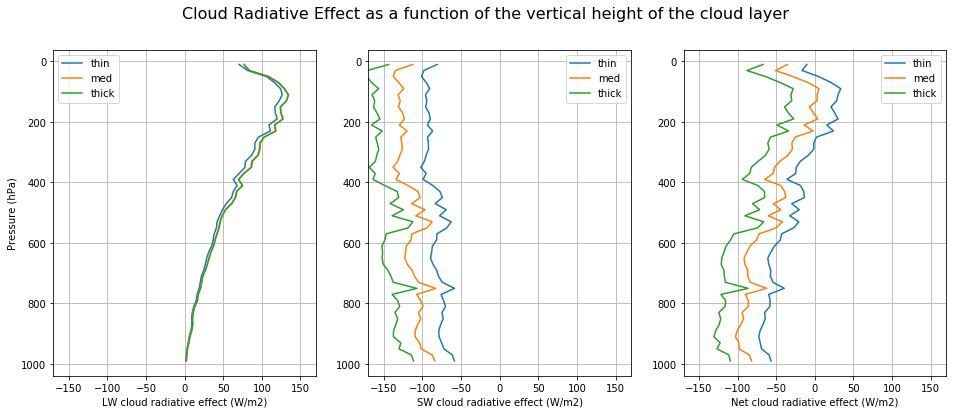

In [12]:
#  Make some plots of the CRE dependence on cloud height
fig, axes = plt.subplots(1,3, figsize=(16,6))
ax = axes[0]
for thickness in clwp:
    ax.plot(CRE_LW[thickness], lev, label=thickness)
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('LW cloud radiative effect (W/m2)')

ax = axes[1]
for thickness in clwp:
    ax.plot(CRE_SW[thickness], lev, label=thickness)
ax.set_xlabel('SW cloud radiative effect (W/m2)')

ax = axes[2]
for thickness in clwp:
    ax.plot(CRE_SW[thickness] + CRE_LW[thickness], lev, label=thickness)
ax.set_xlabel('Net cloud radiative effect (W/m2)')

for ax in axes:
    ax.invert_yaxis()
    ax.legend()
    ax.grid()
    ax.set_xlim(-170,170)
fig.suptitle('Cloud Radiative Effect as a function of the vertical height of the cloud layer', fontsize=16);

What do you see here? Look carefully at how the LW and SW effects of the cloud depend on cloud properties and cloud height.

____________
<a id='section5'></a>

## 5. Cloud feedback
____________

Using our CESM simulations as reference point, how do cloud changes under global warming affect the climate sensitivity?

Is the cloud feedback positive or negative?

What are the contributions from SW and LW processes to this feedback?

We can get some insight into these questions by simply looking at **changes in the Cloud Radiative Effect** between the control and the 2xCO2 simulation.

In [71]:
atm_2xCO2 = xr.open_dataset(datapath+'som_1850_2xCO2/som_1850_2xCO2.cam.h0.clim.nc'+endstr, decode_times=False)

In [72]:
CRE_SW_2xCO2 = atm_2xCO2.FSNT - atm_2xCO2.FSNTC
CRE_LW_2xCO2 = -(atm_2xCO2.FLNT - atm_2xCO2.FLNTC)
CRE_2xCO2 = CRE_SW_2xCO2 + CRE_LW_2xCO2

In [73]:
DeltaCRE_SW = CRE_SW_2xCO2 - CRE_SW_control
DeltaCRE_LW = CRE_LW_2xCO2 - CRE_LW_control
DeltaCRE = CRE_2xCO2 - CRE_control

### Python exercise

Make maps of the changes in annual means:

- $\Delta \text{CRE}_{SW}$
- $\Delta \text{CRE}_{LW}$
- $\Delta \text{CRE}$ (change in net CRE)

For each quantity also calculate the global, annual mean change.

What can we conclude about the cloud feedbacks in CESM?